### Evaluate segmentation approaches against manual annotations

**NOTE**: This will only work if the bounding boxes for annotations are square and labelled with the *Region** class.

#### Instructions for generating initial data files (**necessary before running this notebook**)

1. In the QuPath project containing point annotations from the manual annotators, click the Points tool, opening the Counting window and click "Save points" to save to a .tsv format file.
2. Next, select all annotations (*Ctrl+Alt+A*), and split them (*Objects -> Annotations -> Split*). This will split up the point groups into single point annotation objects.
3. Resolve the hierarchy (*Ctrl+Shift+R* or *Objects -> Annotations -> Resolve hierarchy*). This will allow QuPath to categorize these points as "underneath" the bounding boxes they are inside of.
4. Go to *Measure -> Show Annotation Measurements* and click "Save" to save the entire table to a txt file (include the annotator's name in the file path to keep a record of it). This file is `tsv_path` below.
5. Finally, in the "Image" tab on the left sidebar, get the pixel width and pixel height in microns per pixel and edit the variable below to match it. (*TODO: automate finding this*)

In [1]:
UM_PER_PX = 1.0

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import tifffile as tf
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border, find_boundaries
from skimage.color import label2rgb

In [3]:
from skimage import exposure
def histeq_sqrt(im, nbins=256, mask=None):
    """
    Adjusted skimage algo for "square root"-weighted histogram equalization (that ImageJ uses).
    Results in slighlty less contrast.
    References:
    - https://imagej.nih.gov/ij/source/ij/plugin/ContrastEnhancer.java
    - https://github.com/scikit-image/scikit-image/blob/master/skimage/exposure/exposure.py
    """
    #get image histogram
    if mask is not None:
        hist, bins = exposure.histogram(im[mask], nbins)
    else:
        hist, bins = exposure.histogram(im, nbins)
    hist = np.sqrt(hist)
    img_cdf = hist.cumsum()
    img_cdf = img_cdf / float(img_cdf[-1])
    im2 = np.interp(im.flat, bins, img_cdf)
    return im2.reshape(im.shape)

#### Read annotation data from QuPath

In [4]:
# Reading bounding box data
tsv_path = r"S:\Sources\695_MayoClinic\JC_Villasboas_CODEX\QuPath Annotations\raymond_reg001_annotation_data.txt"
df = pd.read_csv(tsv_path, delimiter='\t')
# Split into two dataframes for points and boxes
pts = df[df["ROI"] == "Points"].copy()
boxes = df[(df["Class"] == "Region*") & (df["ROI"] == "Rectangle")].copy()

In [5]:
# Some validation on the input data
assert (pts["Num points"] == 1).all(), "Point objects do not all contain a single point - did you split the annotations correctly?"
assert not set(boxes.index).intersection(set(pts.index)), "Same annotation is present twice in pts and boxes - should not occur."

In [6]:
boxes["length"] = np.sqrt(boxes["Area µm^2"])
assert (np.isclose(boxes["Perimeter µm"] / 4, boxes["length"])).all(), "Not all bounding boxes appear to be square!"
boxes["x_min"] = boxes["Centroid X µm"] - boxes["length"] / 2
boxes["y_min"] = boxes["Centroid Y µm"] - boxes["length"] / 2
# Convert units to pixels
boxes["length"] = (boxes["length"] / UM_PER_PX).round().astype(int)
boxes["x_min"] = (boxes["x_min"] / UM_PER_PX).round().astype(int)
boxes["y_min"] = (boxes["y_min"] / UM_PER_PX).round().astype(int)

In [7]:
boxes.head()

,Image,Name,Class,Parent,ROI,Centroid X µm,Centroid Y µm,Num points,Area µm^2,Perimeter µm,length,x_min,y_min
3,reg001.ome.tiff - reg001.ome,2,Region*,Image,Rectangle,1202.0,1405.0,NaN,40000.0,800.0,200,1102,1305
6,reg001.ome.tiff - reg001.ome,15,Region*,Image,Rectangle,3981.0,1830.0,NaN,40000.0,800.0,200,3881,1730
21,reg001.ome.tiff - reg001.ome,13,Region*,Image,Rectangle,3567.0,1465.0,NaN,40000.0,800.0,200,3467,1365
56,reg001.ome.tiff - reg001.ome,4,Region*,Image,Rectangle,1536.0,2724.0,NaN,40000.0,800.0,200,1436,2624
73,reg001.ome.tiff - reg001.ome,7,Region*,Image,Rectangle,2388.0,5301.0,NaN,40000.0,800.0,200,2288,5201


In [8]:
# Get names of boxes with points in them
annot_names = pd.unique(pts.loc[pts["Parent"] != "Image", "Parent"]).tolist()
annot_names

['3', '5', '4', 'Test 9', 'Test 6', '14']

In [9]:
# These are the boxes (regions that we need to crop out from the segmentation results)
annot_boxes = boxes[boxes["Name"].isin(annot_names)].reset_index(drop=True)
annot_boxes

,Image,Name,Class,Parent,ROI,Centroid X µm,Centroid Y µm,Num points,Area µm^2,Perimeter µm,length,x_min,y_min
0,reg001.ome.tiff - reg001.ome,4,Region*,Image,Rectangle,1536.0,2724.0,NaN,40000.0,800.0,200,1436,2624
1,reg001.ome.tiff - reg001.ome,Test 6,Region*,Image,Rectangle,1131.0,3883.0,NaN,40000.0,800.0,200,1031,3783
2,reg001.ome.tiff - reg001.ome,3,Region*,Image,Rectangle,1255.0,3212.0,NaN,40000.0,800.0,200,1155,3112
3,reg001.ome.tiff - reg001.ome,Test 9,Region*,Image,Rectangle,718.0,2987.0,NaN,40000.0,800.0,200,618,2887
4,reg001.ome.tiff - reg001.ome,14,Region*,Image,Rectangle,450.0,3910.0,NaN,40000.0,800.0,200,350,3810
5,reg001.ome.tiff - reg001.ome,5,Region*,Image,Rectangle,1579.0,2991.0,NaN,40000.0,800.0,200,1479,2891


In [10]:
# These are the points - only care about X and Y centroid values
pts["x"] = (pts["Centroid X µm"] / UM_PER_PX).round().astype(int)
pts["y"] = (pts["Centroid Y µm"] / UM_PER_PX).round().astype(int)
pts = pts.loc[pts["Parent"].isin(annot_names), ["Image", "Parent", "x", "y"]].reset_index(drop=True)
pts.head()

,Image,Parent,x,y
0,reg001.ome.tiff - reg001.ome,3,1240,3216
1,reg001.ome.tiff - reg001.ome,5,1573,2920
2,reg001.ome.tiff - reg001.ome,4,1488,2749
3,reg001.ome.tiff - reg001.ome,3,1198,3259
4,reg001.ome.tiff - reg001.ome,Test 9,740,3042


#### Match annotation coordinates against segmentation masks

In [11]:
# Original image - just need this to make sure we are matching correctly
# Only read first channel (DAPI)
impath = r"S:/Sources/695_MayoClinic/JC_Villasboas_CODEX/OME_Tiffs_From_Raymond/reg001_correct_resolution.ome.tiff"
# These images can take a while to load, so just read the DAPI (first) channel, which is all we need
with tf.TiffFile(impath) as reader:
    im = reader.asarray(key=0)
im = histeq_sqrt(im)  # optional, enhances contrast

In [12]:
# Cell profiler / Ilastik
# Raymond has this saved as floating point data - we use label to convert it to integer labels
# I do this by finding a consistent diff between values and dividing to upscale the floats to integers
cpi = tf.imread("S:/Sources/695_MayoClinic/JC_Villasboas_CODEX/OME_Tiffs_From_Raymond/Ilastic CP Masks from Raymond/reg001.ome_Probabilities_mask.tiff")
step = np.diff(sorted(np.unique(cpi))).min()
cpi = ((cpi - cpi.min()) / step).astype(np.uint32)
# Stardist pipeline
stardist = tf.imread("reg001_labelimage_stardist.tiff")
# Akoya / CODEX pipeline
codex = tf.imread("reg001_labelimage.tiff")

segmentations = {
    "Cell Profiler / Ilastik": cpi,
    "Stardist": stardist,
    "CODEX": codex
}

In [13]:
# Validation of image size
assert all([seg.shape[0] == im.shape[0] and seg.shape[1] == im.shape[1] for seg in segmentations.values()]), \
       "Segmentation image doesn't match size of original image!"

In [14]:
def generate_integer_cmap(unders, singlets, overs):
    """Generate a colormap which maps integer labels to different colors."""
    cmap_list = [(0,0,0)]
    for i in range(1, max(list(unders) + list(overs) + list(singlets))+1):
        if i in unders:
            cmap_list.append((1,0,0))
        elif i in singlets:
            cmap_list.append((0,1,0))
        elif i in overs:
            cmap_list.append((0,0,1))
        else:
            cmap_list.append((0,0,0))
    return mpl.colors.ListedColormap(cmap_list)

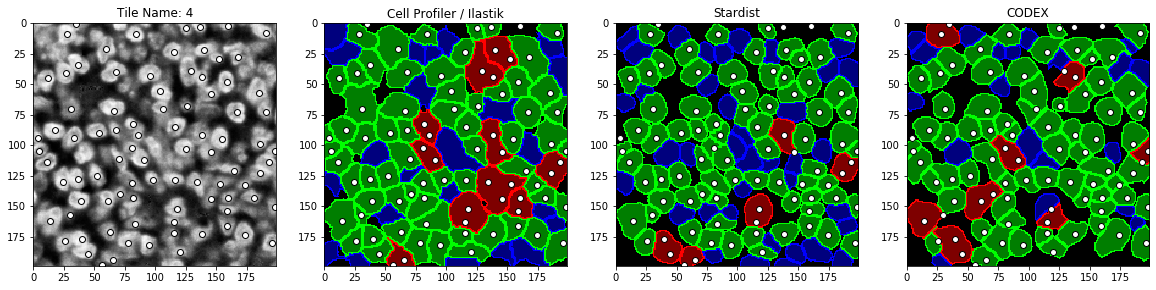

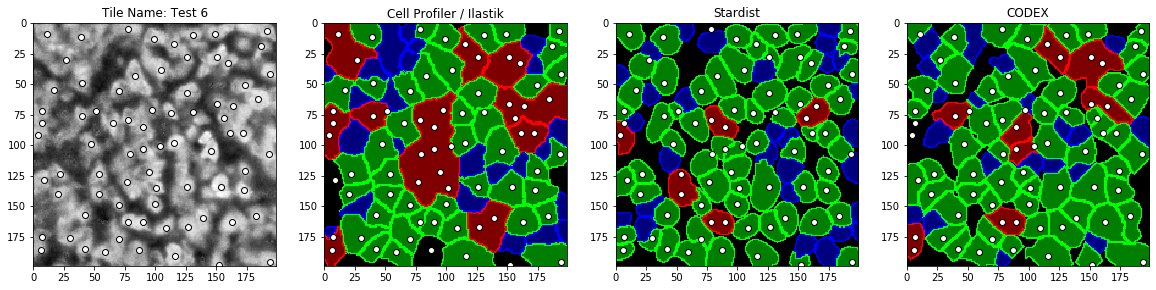

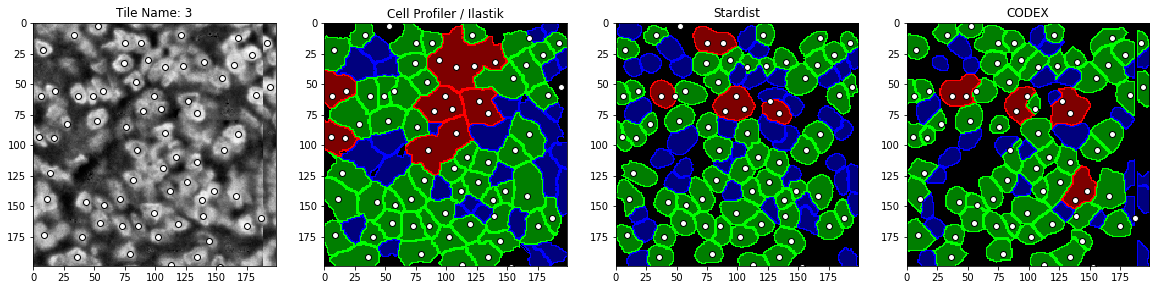

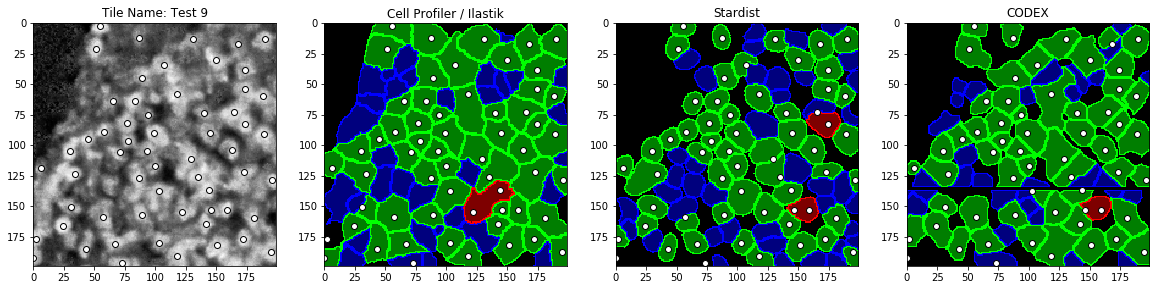

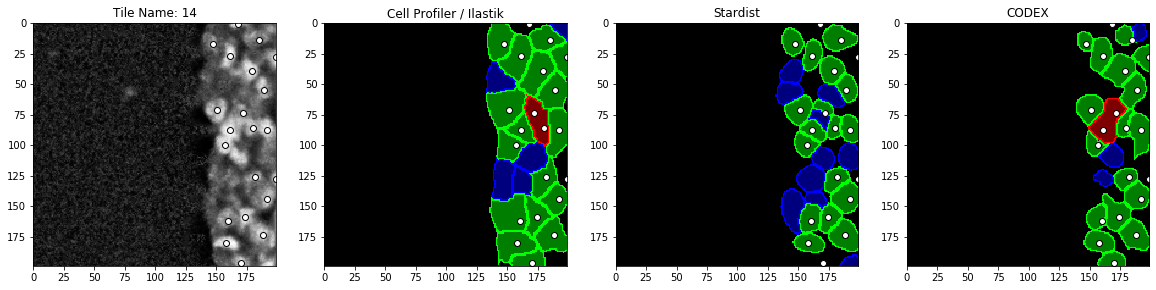

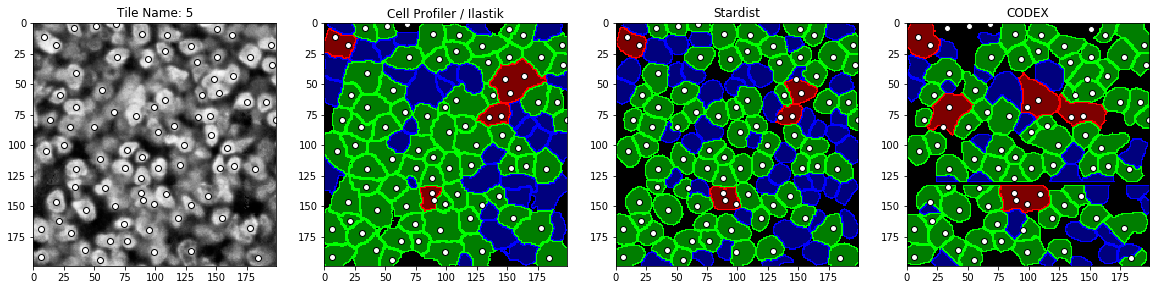

In [15]:
# Initialize results
results = {
    "tile_name": [],
    "segtype": [],
    "n_annotations": [],
    "n_nonzero_annotations": [],
    "n_segmented": [],
    "n_under": [],
    "n_singlets": [],
    "n_over": []
}

for _, row in annot_boxes.iterrows():
    x = row["x_min"]
    y = row["y_min"]
    l = row["length"]
    name = row["Name"]
    patch = tuple(np.ogrid[y:y+l, x:x+l])
    patch_extra = tuple(np.ogrid[y-l:y+2*l, x-l:x+2*l])
    
    # Account for labels at the edge of the cropped bounding box
    # We will remove any labels where their centroid is outside of the annotation box
    segmentations_cropped = {}
    for segtype, segim in segmentations.items():
        # crop whole segmentation image to padded region
        segim = segim[patch_extra]
        for prop in regionprops(segim):
            if not ((l < prop.centroid[0] < l*2) and (l < prop.centroid[1] < l*2)):
                # this cell is not within the bounds
                # remove it from segim
                segim[segim == prop.label] = 0
        # crop padded region to final annotation area 
        segim = segim[l:2*l, l:2*l]
        segmentations_cropped[segtype] = segim
        
#     f, ax = plt.subplots(1, 4, figsize=(20, 5))
#     ax[0].imshow(im[patch], cmap="gray")
#     ax[0].set_title(f"tile name: {name}")
#     palette = np.random.random((1000, 3)) * 0.9 + 0.1   # 1000 is just a big number here to assign unique colours to labels
#     for i, (segtype, segim) in enumerate(segmentations_cropped.items()):
#         ax[i+1].imshow(label2rgb(segim, colors=palette, bg_label=0))
#         ax[i+1].set_title(segtype)

#     # Show points on top
#     for i in range(len(ax)):
#         ax[i].scatter(rel_coords[:,0], rel_coords[:,1], edgecolors="black", color="white")
#         ax[i].set_xlim(0, l-1)
#         ax[i].set_ylim(l-1, 0)

    # Points relative to bounding box
    rel_coords = pts.loc[pts["Parent"] == name, ["x", "y"]].values - np.array([x,y])
    
    # How many total nuclei were annotated?
    n_annotated_cells = len(rel_coords)
    segmentation_results = {}
    segmentation_cmaps = {}

    for segtype, segim in segmentations_cropped.items():
        # How many total nuclei were detected?
        segmented_labels = np.unique(segim[segim != 0])
        n_segmented_cells = len(segmented_labels)

        # Multiply label segmentation image with boolean point mask
        # Create boolean point mask
        pts_mask = np.zeros((l, l), dtype=bool)
        for pt in rel_coords:
            # Need to exclude points that rounded up to (l, l) coordinates
            if (pt[0] < l) and (pt[1] < l):
                pts_mask[pt[1], pt[0]] = True
        # Multiply this against the label image
        pts_mask_labelled = pts_mask * segim
        # Get count of points associated with each cell label
        segmented_cells = pd.value_counts(pts_mask_labelled[pts_mask_labelled != 0].ravel())
        segmented_cells = segmented_cells.reindex(segmented_labels, fill_value=0)  # include cells with 0 points

        # categorize
        unders = segmented_cells[segmented_cells > 1].index
        singlets = segmented_cells[segmented_cells == 1].index
        overs = segmented_cells[segmented_cells == 0].index
        segmentation_results[segtype] = (unders, singlets, overs)
        segmentation_cmaps[segtype] = generate_integer_cmap(unders, singlets, overs)
    
        # Append results to results dict
        results["tile_name"].append(name)
        results["segtype"].append(segtype)
        results["n_annotations"].append(len(rel_coords))
        results["n_nonzero_annotations"].append(len(pts_mask_labelled[pts_mask_labelled != 0].ravel()))
        results["n_segmented"].append(len(segmented_cells))
        results["n_under"].append(len(unders))
        results["n_singlets"].append(len(singlets))
        results["n_over"].append(len(overs))
        
    f, ax = plt.subplots(1, 4, figsize=(20, 5))
    ax[0].imshow(im[patch], cmap="gray")
    ax[0].set_title(f"Tile Name: {name}")
    rel_coords = pts.loc[pts["Parent"] == name, ["x", "y"]].values - np.array([x,y])
    palette = np.random.random((1000, 3)) * 0.9 + 0.1   # 1000 is just a big number here to assign unique colours to labels
    for i, (segtype, segim) in enumerate(segmentations_cropped.items()):
        ax[i+1].imshow(find_boundaries(segim, mode="inner", connectivity=2) * segim, cmap=segmentation_cmaps[segtype])
        ax[i+1].imshow(segim, cmap=segmentation_cmaps[segtype], alpha=0.5)
        ax[i+1].set_title(segtype)

    # Show points on top
    for i in range(len(ax)):
        ax[i].scatter(rel_coords[:,0], rel_coords[:,1], edgecolors="black", color="white")
        ax[i].set_xlim(0, l-1)
        ax[i].set_ylim(l-1, 0)
    plt.savefig(f"{Path(tsv_path).stem}-{name}.png", bbox_inches="tight")

- % Nuclei found (how many of the hand-labeled nuclei centers ended up inside the segmented regions)
- % Singlets (how many of the cell regions with at least one hand-labeled nucleicentercontained exactly one cell center)
- % Unlabelled regions (how many segmented regions did not contain a hand-labeled cell center).

In [16]:
results_df = pd.DataFrame(results)
results_df["% Predicted"] = results_df["n_segmented"] /  results_df["n_annotations"] * 100
results_df["% Nuclei found"] = results_df["n_nonzero_annotations"] /  results_df["n_annotations"] * 100
results_df["% Singlets"] = results_df["n_singlets"] / (results_df["n_under"] + results_df["n_singlets"]) * 100
results_df["% Unlabelled regions"] = results_df["n_over"] / results_df["n_segmented"] * 100
results_df["% Merged regions"] = results_df["n_under"] / results_df["n_segmented"] * 100

In [17]:
results_df

,tile_name,segtype,n_annotations,n_nonzero_annotations,n_segmented,n_under,n_singlets,n_over,% Predicted,% Nuclei found,% Singlets,% Unlabelled regions,% Merged regions
0,4,Cell Profiler / Ilastik,88,86,98,10,65,23,111.363636,97.727273,86.666667,23.469388,10.204082
1,4,Stardist,88,84,118,5,74,39,134.090909,95.454545,93.670886,33.050847,4.237288
2,4,CODEX,88,84,96,8,68,20,109.090909,95.454545,89.473684,20.833333,8.333333
3,Test 6,Cell Profiler / Ilastik,77,76,80,10,46,24,103.896104,98.701299,82.142857,30.000000,12.500000
4,Test 6,Stardist,77,76,100,5,66,29,129.870130,98.701299,92.957746,29.000000,5.000000
5,Test 6,CODEX,77,75,88,8,59,21,114.285714,97.402597,88.059701,23.863636,9.090909
6,3,Cell Profiler / Ilastik,69,66,85,6,51,28,123.188406,95.652174,89.473684,32.941176,7.058824
7,3,Stardist,69,67,102,4,58,40,147.826087,97.101449,93.548387,39.215686,3.921569
8,3,CODEX,69,67,92,4,59,29,133.333333,97.101449,93.650794,31.521739,4.347826
9,Test 9,Cell Profiler / Ilastik,59,58,89,1,56,32,150.847458,98.305085,98.245614,35.955056,1.123596


In [18]:
tidy = results_df.melt("segtype", value_vars=["% Predicted", "% Nuclei found", "% Singlets", "% Unlabelled regions", "% Merged regions"], var_name="Metric")

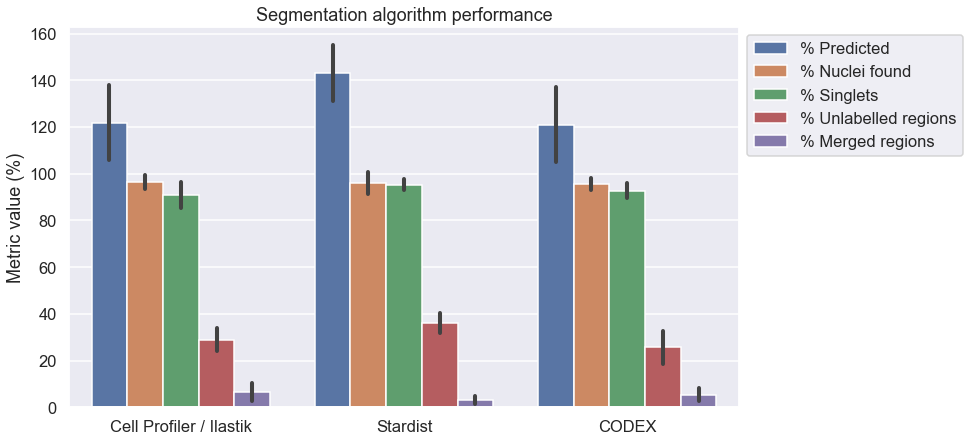

In [19]:
sns.set(context="talk")
f, ax = plt.subplots(figsize=(12, 7))
sns.barplot(
    x="segtype",
    y="value",
    hue="Metric",
    ci="sd",
    data=tidy,
    ax=ax
)
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel(None)
ax.set_ylabel("Metric value (%)")
ax.set_title("Segmentation algorithm performance")
plt.savefig(f"{Path(tsv_path).stem}_results.png", bbox_inches="tight")